In [2]:
using CSV
using DataFrames
using Plots
using Plots: mm
using Flux
using Statistics
using StatsBase: sample
using Statistics: mean
import Random

# DNN for PK modeling

## Preparing Data

In [3]:
file = "../../../data/warfarin.csv"
df = CSV.read(file, DataFrame);

In [4]:
first(df,5)

Row,ID,TIME,WEIGHT,AGE,SEX,CMT,AMT,DVID,DV,MDV,MDVPK
,Int64,Float64,Float64,Int64,Int64,Int64,Float64?,Int64,Float64?,Int64,Int64
1,100,0.0,66.7,50,1,1,100.0,1,missing,1,1
2,100,0.5,66.7,50,1,2,missing,1,0.0,0,0
3,100,1.0,66.7,50,1,2,missing,1,1.9,0,0
4,100,2.0,66.7,50,1,2,missing,1,3.3,0,0
5,100,3.0,66.7,50,1,2,missing,1,6.6,0,0


In [5]:
# Forward fill missing values in column 'AMT'. As the AMT is the dose and only appear on the first colum for each patient
for i in 2:size(df, 1)
    if ismissing(df.AMT[i])
        df.AMT[i] = df.AMT[i-1]
    end
end

# Then delete dose obervation
dropmissing!(df, :DV);

In [6]:
# Divide datasets: when DVID = 1, we have data for PK and when DVID = 2, we have data for PD
df_pk = df[(df.DVID .== 1), :];

In [7]:
# Select columns
df_pk = select(df_pk, [:ID, :TIME, :WEIGHT, :AGE, :SEX, :AMT, :DV]);

# Convert column types to float
for i in ["WEIGHT", "AGE", "AMT","DV"]
    df_pk[!,i] = convert.(Float32, df_pk[!,i]);
end



In [8]:
# Only keep values where DV is larger than 0
df_pk = df_pk[df_pk.DV .> 0, :];

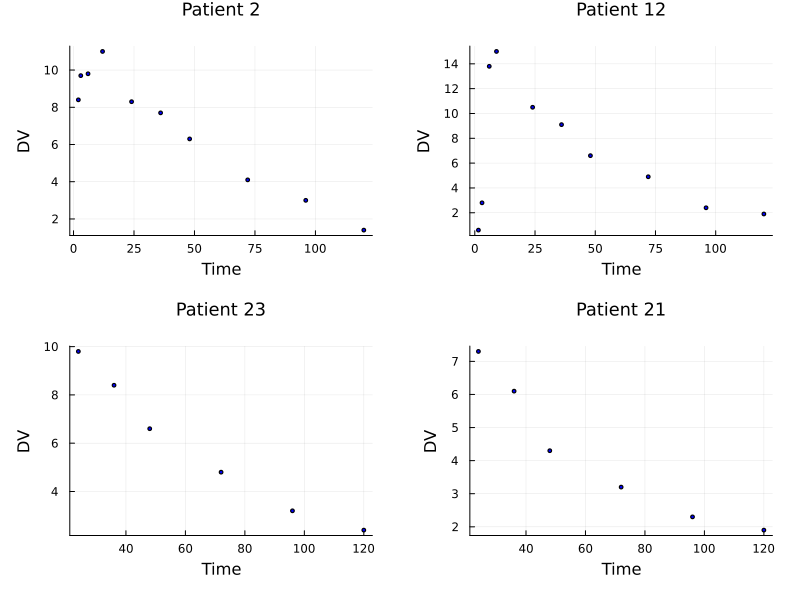

In [9]:
# Graph 4 random patients
Random.seed!(1)

patients = unique(df_pk.ID);

# Create an array to store scatter plots
scatter_plots = Plots.Plot[]

# Loop through each patient
for i in patients[rand(1:length(patients), 4)]
    df_plot = df_pk[df_pk.ID .== i, :]
   
    x_values = df_plot.TIME
    y_values = df_plot.DV

    push!(scatter_plots, scatter(x_values, 
                                 y_values,
                                 xlabel="Time",
                                 ylabel="DV",
                                 title="Patient $i",
                                 legend = false,
                                 markersize=2,
                                 markercolor=:blue,
                                 titlefont=font(12)
                                 )
            )
end

# Combine scatter plots into a grid layout
plot_grid = plot(scatter_plots..., layout=(2, 2), size=(800, 600), margin=5mm)

# Show the combined plot
display(plot_grid)

## Modeling

In [80]:
# Column order requirement
column_order() = ["TIME", "WEIGHT", "AGE", "SEX", "AMT"]

column_order (generic function with 1 method)

In [81]:
function normalize_df(X_train; X_test = nothing, col_abs = ["WEIGHT", "AGE", "AMT"]) 
    
    scaler = Dict()
    for i in ["WEIGHT", "AGE", "AMT"]
        scaler[i] = maximum(abs.(X_train[:,i]))
        X_train[:, i] = X_train[:, i] ./ scaler[i]
        if X_test !== nothing
            X_test[:, i]= X_test[:, i] ./ scaler[i]
        end
    end
    
    return X_train, X_test, scaler
end

normalize_df (generic function with 1 method)

In [141]:
# Neural Network Builder
function dnn()

    return Flux.Chain(
        Flux.Dense(5, 8, Flux.swish),
        Flux.Dense(8, 4, Flux.swish),
        Flux.Dense(4, 1, Flux.softplus)
    )

end

dnn (generic function with 1 method)

In [142]:
function train_model(model, X_train, y_train; X_test = nothing, y_test = nothing, epochs = 10, plot_epochs = true, batchsize = nothing)
  if batchsize === nothing
    batchsize = nrow(X_train)
  end

  train_loss = Float32[]
  test_loss = Float32[]
  
  train_mae = Float32[]
  test_mae = Float32[]

  opt = Flux.setup(Adam(1e-3), model)
  for epoch in 1:epochs
    if epoch == 300      
      Flux.adjust!(opt, 1e-3)
    end

    batches = Flux.DataLoader((X_train, y_train), batchsize=batchsize, shuffle=true)
    for (X, y) in batches
      X = Matrix(X)'
      y = y'
      val, grads = Flux.withgradient(model) do m
          # Any code inside here is differentiated.
          # Evaluation of the model and loss must be inside
          result = m(X)
          Flux.mse(result, y)
        end

      # Detect loss of Inf or NaN. Print a warning, and then skip update
      if !isfinite(val)
        @warn "loss is $val"
        continue
      end

      # Update parameters
      Flux.update!(opt, model, grads[1])

    end
    # Calculate epoch's train MSE and MAE
    push!(train_loss, Flux.mse(model(Matrix(X_train)'), y_train'))
    push!(train_mae, Flux.mae(model(Matrix(X_train)'), y_train'))

    #Calculate epoch's test MSE and MAE
    if X_test !== nothing
      push!(test_mae, Flux.mae(model(Matrix(X_test)'), y_test'))
      push!(test_loss, Flux.mse(model(Matrix(X_test)'), y_test'))
    end
  end

  println("Final train MAE is $(train_mae[end])")
  if X_test !== nothing
    println("Final test MAE is $(test_mae[end])")
  end

  #Plot
  if plot_epochs
    plt = plot(size=(800, 400), xlabel="Epochs", ylabel="MAE", title="MAE")
    plot!(plt, train_mae, label="Train MAE")
    if X_test !== nothing
        plot!(plt, test_mae, label="Test MAE")
    end
    display(plt)
  end
  return model
end

train_model (generic function with 2 methods)

In [154]:
# Training via K folds
# The dataset is randomly split 75-25 and the model is trained. This is done folds times
function kfolds_training(df; epochs = 500, folds = 5, col_abs = ["WEIGHT", "AGE", "AMT"], plot_epochs=True, batchsize = nothing)
    
    cols = column_order()
    subjects = unique(df.ID)

    mae_train = Float32[]
    mae_test = Float32[]

    count_folds = 0
    iter = 0
    while count_folds < folds && iter < folds*2
        # 25% of subjects go to test
        test_subjects = sample(subjects, div(length(subjects), 4), replace=false)
        data_train = df[.!in.(df.ID, Ref(test_subjects)), :]
        data_test = df[in.(df.ID, Ref(test_subjects)), :]

        # Train and test splits
        X_train = data_train[!, cols]
        y_train = data_train[:, "DV"]
        
        X_test = data_test[!, cols]
        y_test = data_test[:, "DV"]
        
        # Normalize df
        X_train, X_test, scaler = normalize_df(X_train, X_test=X_test, col_abs=col_abs)

        count_folds += 1
        iter += 1

        model =  dnn()
        model = train_model(model, X_train, y_train, X_test=X_test, y_test=y_test, epochs=epochs, plot_epochs=plot_epochs, batchsize=batchsize)

        push!(mae_train, Flux.mae(model(Matrix(X_train)'), y_train'))
        push!(mae_test, Flux.mae(model(Matrix(X_test)'), y_test'))
    end
    println()
    println("Mean MAE across all folds - Train: $(mean(mae_train))")
    println("Mean MAE across all folds - Test: $(mean(mae_test))")
end

kfolds_training(df_pk; epochs = 3000, folds = 5, col_abs = ["WEIGHT", "AGE", "AMT",], plot_epochs=false, batchsize = nothing)

Final train MAE is 1.1231536
Final test MAE is 1.3904011
Final train MAE is 1.1174965
Final test MAE is 1.4255688
Final train MAE is 1.0893172
Final test MAE is 1.8545066
Final train MAE is 2.2248902
Final test MAE is 2.2554739
Final train MAE is 1.0870534
Final test MAE is 1.4267873

Mean MAE across all folds - Train: 1.3283823
Mean MAE across all folds - Test: 1.6705475


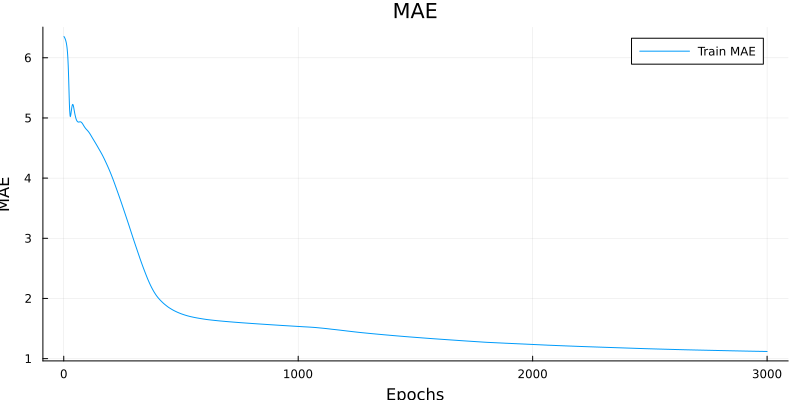

Final train MAE is 1.1189802

Final MAE: 1.1189801281280363


In [316]:
function full_training(df; epochs=2000)
    cols = column_order()

    X = df[:, cols]
    y = df[:, "DV"]

    X_train, _, scaler = normalize_df(X, X_test=nothing, col_abs=["WEIGHT", "AGE", "AMT"])

    model =  dnn()
    model = train_model(model, X_train, y_train, X_test=nothing, y_test=nothing, epochs=epochs, plot_epochs=true, batchsize=nothing)

    println()
    println("Final MAE: $(Flux.mae(model(Matrix(X_train)'), y_train'))")

    return model, scaler

end

model, scaler = full_training(df_pk, epochs=3000);

## Predictions

### Predictions for existing patient

In [347]:
"""
Function to make predictions for a patient and plot them
"""
function predict_patient(df, model, scaler; max_time=120, patient_id=nothing, plot_series=true, plot_true_labels=true)
    # Predict and plot
    cols = column_order()
    time = 0:(max_time-1)
    weight = df.WEIGHT[1]
    age = df.AGE[1]
    sex = df.SEX[1]
    amt = df.AMT[1]
    df_predicted = DataFrame(
        TIME = time,
        WEIGHT = fill(weight, length(time)),
        AGE = fill(age, length(time)),
        SEX = fill(sex, length(time)),
        AMT = fill(amt, length(time))
    )

    for (key, value) in scaler
        df_predicted[:, key] = df_predicted[:, key] ./ value
    end
    predicted = model(Matrix(df_predicted)')

    df_predicted[:,"predicted"] = vec(predicted)

    # Create the initial plot with the line plot
    if plot_series
        plt = plot(df_predicted.TIME, df_predicted.predicted, 
                    label="Predicted", xlabel="Time", ylabel="Concentration",
                    color = :black,
                    size=(600,300))
        if patient_id !== nothing
            plot!(plt, title = "Patient $patient_id")
        end

        # Add the scatter plot to the existing plot
        if plot_true_labels
            scatter!(plt, df.TIME, df_subject.DV, label="DV", color=:blue, markersize=3)
        end
        
        display(plt)
    end
    return df_predicted
end


predict_patient

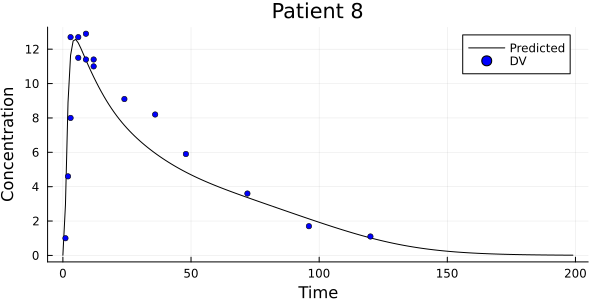

In [354]:
# Set seed for reproducibility
#Random.seed!(1)

# Choose a random example
example = rand(subjects)  # Assuming subjects is a list of patient IDs
example = 8  # Alternatively, you can directly specify the example ID

# Filter DataFrame for the selected example
df_subject = filter(row -> row.ID == example, df_pk)

# Predict and plot
df_predicted = predict_patient(df_subject, model, scaler, max_time=200, patient_id=example, plot_series=true, plot_true_labels=true);


### Predictions for new patient

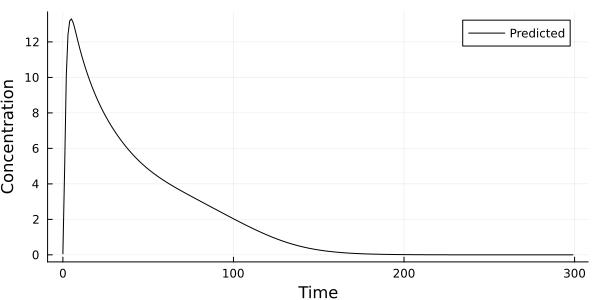

In [437]:
# Predict for artificial patient

df_test = DataFrame(WEIGHT = [50], AGE = [27], SEX = [0], AMT = [100])

# Convert column types to float
for i in ["WEIGHT", "AGE", "AMT"]
    df_test[!,i] = convert.(Float32, df_test[!,i]);
end

_ = predict_patient(df_test, model, scaler, max_time=300, patient_id=nothing, plot_series=true, plot_true_labels=false);


### Predictions when changing covariates

In [388]:
function test_variables(df_subject, model, scaler; max_time=200, variable="AMT", values=[0, 1, 10, 50, 100, 200, 500])

    colors = Plots.palette(:viridis, length(values))

    d = copy(df_subject)
    plt = plot(label="Predicted", xlabel="Time", ylabel="Concentration", size=(600,300))
    for (i, val) in enumerate(values)
        d[:, variable] .= val
        df_predicted = predict_patient(d, model, scaler, max_time=max_time, plot_series=false)
        plot!(df_predicted.TIME, df_predicted.predicted, linewidth=1, label="$variable=$val", linecolor=colors[i])
    end
    display(plt)

end

# Get some base client to start simulations
df_test = DataFrame(WEIGHT = [70], AGE = [40], SEX = [0], AMT = [100])
# Convert column types to float
for i in ["WEIGHT", "AGE", "AMT"]
    df_test[!,i] = convert.(Float32, df_test[!,i]);
end

#### Change AMT

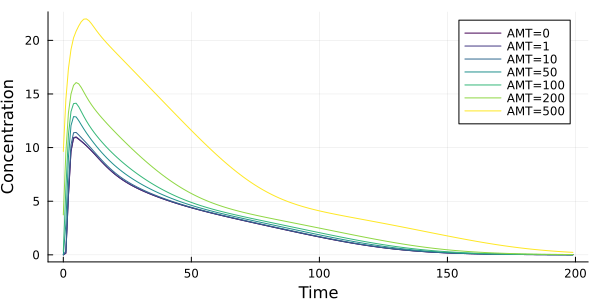

In [389]:
test_variables(df_test, model, scaler, max_time=200, 
               variable="AMT", 
               values=[0, 1, 10, 50, 100, 200, 500]
              )

#### Change Weight

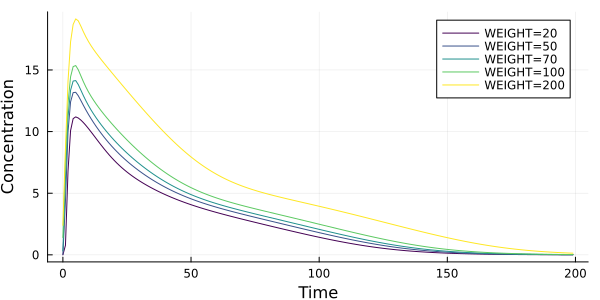

In [390]:
test_variables(df_test, model, scaler, max_time=200, 
                variable = "WEIGHT", 
                values = [20, 50, 70, 100, 200], 
              )

#### Change Age

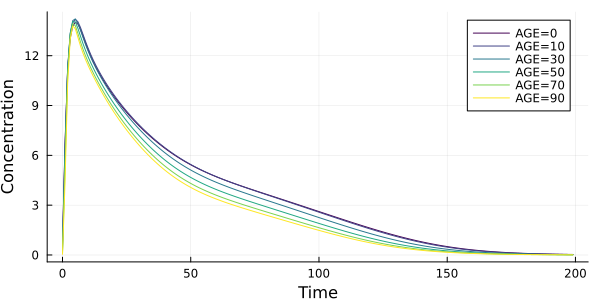

In [391]:
test_variables(df_test, model, scaler, max_time = 200, 
               variable = "AGE", 
               values = [0, 10, 30, 50, 70, 90])

#### Change Sex

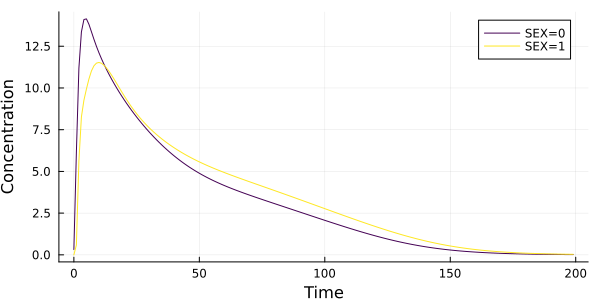

In [392]:
test_variables(df_test, model, scaler, max_time = 200, 
               variable = "SEX", 
               values = [0, 1])

### Predictions with multiple doses

In [434]:
function multiple_doses(df_test; time_simulation=300, time_new_dose = [], new_dose = [])

    new_dose = Float64.(new_dose)

    # Base simulation
    df_predicted = predict_patient(df_test, model, scaler, max_time=time_simulation, 
                                    plot_series=false, plot_true_labels=false)

    for (ix, dose) in enumerate(new_dose)

        # Predict PK with new dose
        df_test.AMT .= dose
        df_predicted_redose = predict_patient(df_test, model, scaler, max_time=time_simulation - time_new_dose[ix],
                                        plot_series=false, plot_true_labels=false)
        
        # The new dose was given at time_new_dose, so offset the time                                
        df_predicted_redose.TIME .+= time_new_dose[ix]

        # Join predictions and fill times where values are missing as zero
        df_predicted = leftjoin(df_predicted, df_predicted_redose, on=:TIME, makeunique=true)
        df_predicted.predicted_1 = coalesce.(df_predicted.predicted_1, 0)

        # Add predictions for each time point
        df_predicted.predicted = df_predicted.predicted + df_predicted.predicted_1

        # Clean
        select!(df_predicted, Not(:predicted_1))
        df_predicted = sort(df_predicted, :TIME)

    end
    plt = plot(df_predicted.TIME, df_predicted.predicted, 
                label="Predicted", xlabel="Time", ylabel="Concentration",
                color = :black,
                size=(600,300))
    display(plt)
end



multiple_doses (generic function with 1 method)

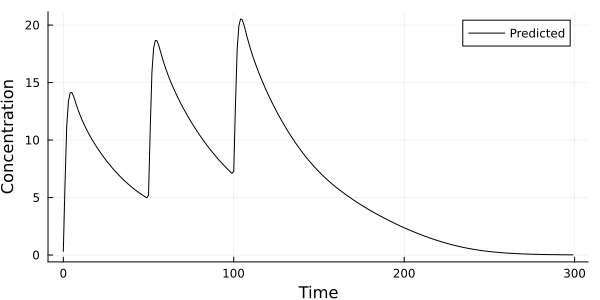

In [435]:
# Get some base client to start simulations
df_test = DataFrame(WEIGHT = [70], AGE = [40], SEX = [0], AMT = [100])
# Convert column types to float
for i in ["WEIGHT", "AGE", "AMT"]
    df_test[!,i] = convert.(Float32, df_test[!,i]);
end

multiple_doses(df_test, time_simulation=300, time_new_dose=[50, 100], new_dose=[100, 100])